## Methodology for number's prediction of bicycle passing between 00:01 AM and 09:00 AM on Friday, April 2nd

**Import Packages** 

In [1]:
import pandas as pd
import numpy as np
import datetime as dt 
import matplotlib.pyplot as plt
from download import download 
import warnings 
from fbprophet import Prophet
import statsmodels.api as sm
import seaborn as sns
import sys

**Download Data**

In [2]:
url ='https://docs.google.com/spreadsheets/d/e/2PACX-1vQVtdpXMHB4g9h75a0jw8CsrqSuQmP5eMIB2adpKR5hkRggwMwzFy5kB-AIThodhVHNLxlZYm8fuoWj/pub?gid=2105854808&single=true&output=csv'
path_target = "./totem.csv"
download(url, path_target, replace=True)
df_totem = pd.read_csv("totem.csv", converters={'Date': str, 'Heure / Time': str})
df_totem.tail(n=20)



file_sizes: 50.3kB [00:00, 6.61MB/s]                                            
Successfully downloaded file to ./totem.csv


,Date,Heure / Time,Vélos depuis le 1er janvier / Grand total,Vélos ce jour / Today's total,Unnamed: 4,Remarque
1485,29/03/2021,09:33:00,105538.0,358.0,NaN,NaN
1486,29/03/2021,10:45:00,105625.0,445.0,NaN,NaN
1487,29/03/2021,14:00:00,105906.0,726.0,NaN,NaN
1488,29/03/2021,15:43:00,106049.0,869.0,NaN,NaN
1489,29/03/2021,16:09:00,106090.0,910.0,NaN,NaN
1490,29/03/2021,16:42:00,106177.0,997.0,NaN,NaN
1491,29/03/2021,18:49:00,106620.0,1440.0,NaN,NaN
1492,30/03/2021,08:35:00,107125.0,249.0,NaN,NaN
1493,30/03/2021,09:12:00,107247.0,371.0,NaN,NaN
1494,30/03/2021,09:24:00,107266.0,390.0,NaN,NaN


**Clean Data**

In [3]:
df_totem.info()

#Rename columns 
df_totem.rename(columns = {'''Vélos ce jour / Today's total''': 'Day_Total','Heure / Time':'Time'}, inplace=True)
#Sort rows regarding to index
df_totem = df_totem.sort_index(ascending=True)

df_totem.head(n=15)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1505 entries, 0 to 1504
Data columns (total 6 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Date                                       1505 non-null   object 
 1   Heure / Time                               1505 non-null   object 
 2   Vélos depuis le 1er janvier / Grand total  1503 non-null   float64
 3   Vélos ce jour / Today's total              1503 non-null   float64
 4   Unnamed: 4                                 0 non-null      float64
 5   Remarque                                   1 non-null      object 
dtypes: float64(3), object(3)
memory usage: 70.7+ KB


,Date,Time,Vélos depuis le 1er janvier / Grand total,Day_Total,Unnamed: 4,Remarque
0,,,NaN,NaN,NaN,NaN
1,,,NaN,NaN,NaN,NaN
2,12/03/2020,11:05:00,109.0,109.0,NaN,NaN
3,12/03/2020,14:30:00,441.0,441.0,NaN,NaN
4,13/03/2020,10:02:00,1921.0,385.0,NaN,NaN
5,13/03/2020,14:15:00,2305.0,769.0,NaN,NaN
6,13/03/2020,18:21:00,2822.0,1286.0,NaN,NaN
7,13/03/2020,18:25:00,2834.0,1298.0,NaN,NaN
8,14/03/2020,16:26:43,3951.0,642.0,NaN,estimation
9,15/03/2020,09:05:50,4492.0,50.0,NaN,NaN


Change DateTime format 

In [4]:
#Change format of date : 
time_improved = pd.to_datetime(df_totem['Date'] + ' ' + df_totem['Time'], format="%d/%m/%Y %H:%M:%S", errors='coerce')
df_totem['DateTime'] = time_improved

#We filter DateTime in order to adjust data to target prediction 
df_totem= df_totem[(df_totem['Time']> '00:00') & (df_totem['Time'] < '09:01')]

#Remove useless columns 
df_totem.drop(columns=['Vélos depuis le 1er janvier / Grand total','Time', 'Unnamed: 4','Remarque','Date'], inplace=True)
df_totem
df_totem.set_index('DateTime')

,Day_Total
DateTime,
2020-03-16 06:57:00,14.0
2020-03-16 08:12:00,74.0
2020-03-16 08:24:00,93.0
2020-03-17 08:00:00,40.0
2020-03-17 08:39:00,80.0
...,...
2021-03-26 08:28:00,190.0
2021-03-27 08:29:00,52.0
2021-03-28 07:50:00,35.0


**Data Analysis**

*Visualizing time series*


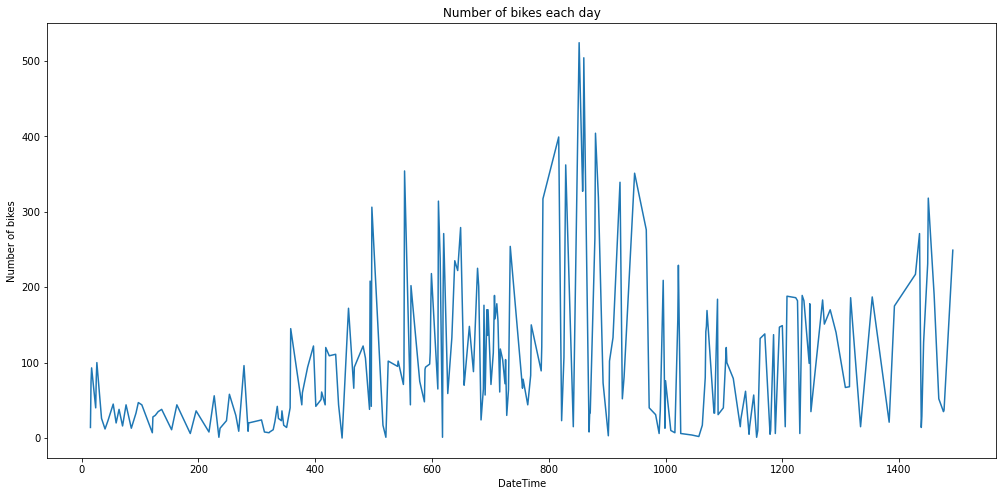

In [5]:
plt.figure(figsize=(17, 8))
plt.plot(df_totem.Day_Total)
plt.title('Number of bikes each day')
plt.ylabel('Number of bikes')
plt.xlabel('DateTime')
plt.grid(False)
plt.show()

We observe seasonality.

Check if Time Series Data is Stationary with augmented Dickey-Fuller test : 

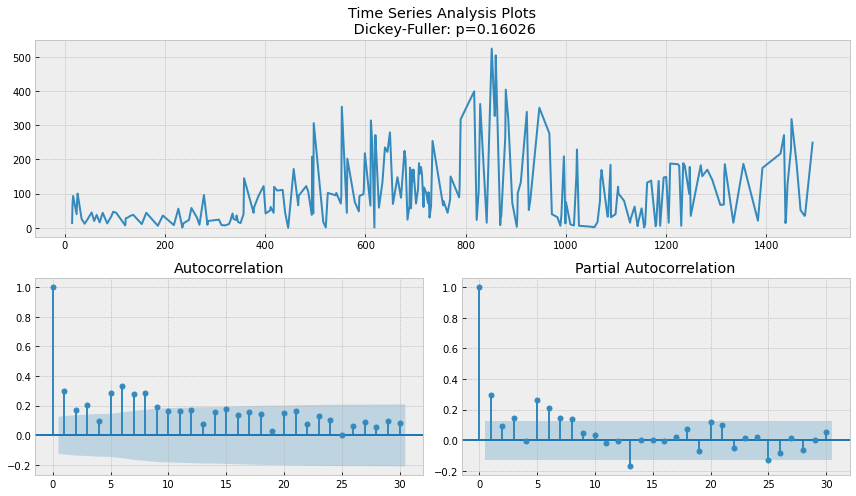

In [6]:
import statsmodels.tsa.api as smt

def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(df_totem.Day_Total, lags=30)

p-value > 0.05 : Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary

***Prediction***

Format Data for fbProphet method

In [7]:
#tiemestamp must be datetime types so we can use 

df_totem['ds'] = pd.to_datetime(df_totem['DateTime'])
df_totem['Day_Of_Week'] = df_totem.DateTime.dt.dayofweek
df_totem['Day_Of_Year'] = df_totem.DateTime.dt.dayofyear
df_totem["Day"] = pd.DatetimeIndex(df_totem["DateTime"]).day
df_totem["weekday"] =  df_totem["DateTime"].dt.day_name()
df_totem['Month'] = df_totem.DateTime.dt.month
df_totem['Year'] = df_totem.DateTime.dt.year
df_totem["hour"] = df_totem.DateTime.dt.hour
df_totem["minute"] = df_totem.DateTime.dt.minute
df_totem


,Day_Total,DateTime,ds,Day_Of_Week,Day_Of_Year,Day,weekday,Month,Year,hour,minute
15,14.0,2020-03-16 06:57:00,2020-03-16 06:57:00,0,76,16,Monday,3,2020,6,57
16,74.0,2020-03-16 08:12:00,2020-03-16 08:12:00,0,76,16,Monday,3,2020,8,12
17,93.0,2020-03-16 08:24:00,2020-03-16 08:24:00,0,76,16,Monday,3,2020,8,24
24,40.0,2020-03-17 08:00:00,2020-03-17 08:00:00,1,77,17,Tuesday,3,2020,8,0
25,80.0,2020-03-17 08:39:00,2020-03-17 08:39:00,1,77,17,Tuesday,3,2020,8,39
...,...,...,...,...,...,...,...,...,...,...,...
1460,190.0,2021-03-26 08:28:00,2021-03-26 08:28:00,4,85,26,Friday,3,2021,8,28
1468,52.0,2021-03-27 08:29:00,2021-03-27 08:29:00,5,86,27,Saturday,3,2021,8,29
1476,35.0,2021-03-28 07:50:00,2021-03-28 07:50:00,6,87,28,Sunday,3,2021,7,50
1477,37.0,2021-03-28 08:21:00,2021-03-28 08:21:00,6,87,28,Sunday,3,2021,8,21


In [8]:
df_totem.drop(columns=['Month','Year', 'hour','Day_Of_Week','Day_Of_Year','Day','weekday','minute','DateTime'], inplace=True)
#df_totem.columns =['y','ds']

The package requires 2 varaibles, "ds" : datetime type and "y" column of integers

In [9]:
df_totem.columns =['y','ds']
df_totem = df_totem.astype({"y": int})
df_totem

,y,ds
15,14,2020-03-16 06:57:00
16,74,2020-03-16 08:12:00
17,93,2020-03-16 08:24:00
24,40,2020-03-17 08:00:00
25,80,2020-03-17 08:39:00
...,...,...
1460,190,2021-03-26 08:28:00
1468,52,2021-03-27 08:29:00
1476,35,2021-03-28 07:50:00
1477,37,2021-03-28 08:21:00


**Train Model**

In [10]:
# Python
m = Prophet()
m.add_country_holidays(country_name='FR')


**Forcast Away**


In [11]:
m = Prophet(interval_width=0.95)
model = m.fit(df_totem)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [12]:
#Create future date for prediction
future = m.make_future_dataframe(periods=10, freq='D')
#prediction
forecast = m.predict(future)
forecast.tail(n=20)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
233,2021-03-24 07:40:00,97.066407,-57.826291,165.409970,97.066407,97.066407,-45.312697,-45.312697,-45.312697,-45.063635,-45.063635,-45.063635,-0.249062,-0.249062,-0.249062,0.0,0.0,0.0,51.753710
234,2021-03-24 07:50:00,97.064555,-53.355825,169.209409,97.064555,97.064555,-34.689729,-34.689729,-34.689729,-34.413017,-34.413017,-34.413017,-0.276711,-0.276711,-0.276711,0.0,0.0,0.0,62.374827
235,2021-03-24 08:00:00,97.062704,-37.624169,188.161391,97.062704,97.062704,-21.673493,-21.673493,-21.673493,-21.369738,-21.369738,-21.369738,-0.303754,-0.303754,-0.303754,0.0,0.0,0.0,75.389211
236,2021-03-25 08:28:00,96.790867,28.619668,246.490633,96.790867,96.790867,42.036145,42.036145,42.036145,28.708311,28.708311,28.708311,13.327834,13.327834,13.327834,0.0,0.0,0.0,138.827012
237,2021-03-25 08:50:00,96.786793,81.851264,306.888634,96.786793,96.786793,95.707553,95.707553,95.707553,81.836059,81.836059,81.836059,13.871494,13.871494,13.871494,0.0,0.0,0.0,192.494346
238,2021-03-26 08:28:00,96.524215,44.657146,274.551308,96.524215,96.524215,63.727526,63.727526,63.727526,28.708311,28.708311,28.708311,35.019215,35.019215,35.019215,0.0,0.0,0.0,160.251741
239,2021-03-27 08:29:00,96.257378,-15.524078,217.252322,96.257378,96.257378,3.150123,3.150123,3.150123,30.869550,30.869550,30.869550,-27.719426,-27.719426,-27.719426,0.0,0.0,0.0,99.407501
240,2021-03-28 07:50:00,95.997948,-86.461922,136.280457,95.997948,95.997948,-71.061759,-71.061759,-71.061759,-34.413017,-34.413017,-34.413017,-36.648741,-36.648741,-36.648741,0.0,0.0,0.0,24.936189
241,2021-03-28 08:21:00,95.992207,-36.746354,190.004356,95.992207,95.992207,-21.333569,-21.333569,-21.333569,14.292017,14.292017,14.292017,-35.625586,-35.625586,-35.625586,0.0,0.0,0.0,74.658638
242,2021-03-30 08:35:00,95.456311,37.908090,254.297809,95.456311,95.456311,50.214983,50.214983,50.214983,44.361121,44.361121,44.361121,5.853863,5.853863,5.853863,0.0,0.0,0.0,145.671294


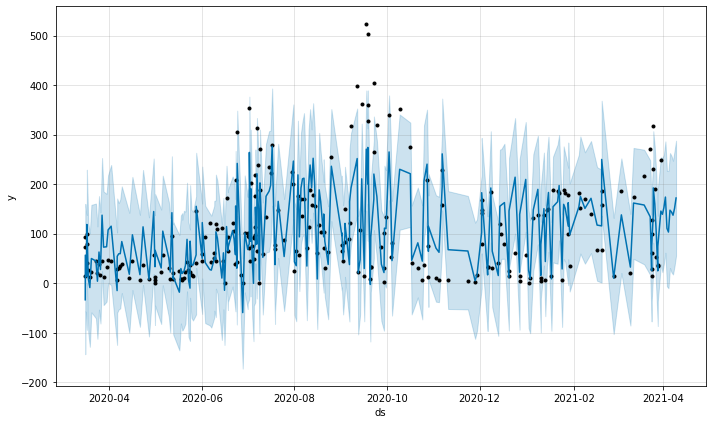

In [13]:
plot1=m.plot(forecast)
plt.savefig("forcast.png", dpi=1500)

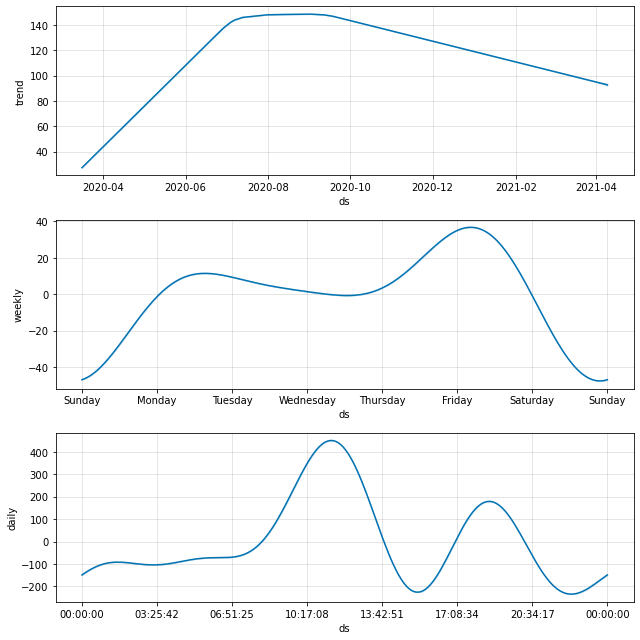

In [14]:
#Plot the trend and seasonality components of the forecast
#The holiday effects shows up in the the comonenets plot.
plot2 = m.plot_components(forecast)

In [15]:

df_mask=forecast['ds']=='2021-04-02 08:35:00'
filtred_df = forecast[df_mask]
filtred_df

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
245,2021-04-02 08:35:00,94.656355,61.487166,286.329845,94.555374,94.755367,79.27779,79.27779,79.27779,44.361121,44.361121,44.361121,34.91667,34.91667,34.91667,0.0,0.0,0.0,173.934145


Adding ChangePoints to Prophet: Changepoints are the datetime points where the time series have abrupt changes in the trajectory.Prophet adds 25 changepoints to the initial 80% of the data-set.
Let’s plot the vertical lines where the potential changepoints occurred.

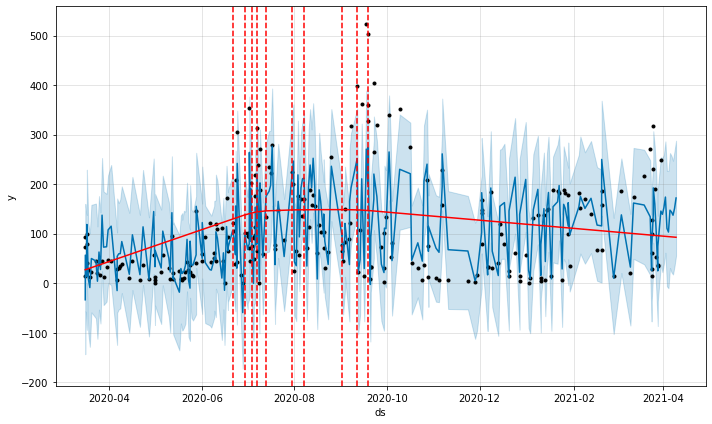

In [17]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

We can view the dates where the chagepoints occurred. We can see that most changements occured during summer.


Plot Error

In [1]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='45 days', period='10 days', horizon = '5 days')


NameError: name 'm' is not defined

In [ ]:
df_cv
